In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [13]:
!pip install keract

     |████████████████████████████████| 378kB 4.1MB/s 
  Found existing installation: Keras 2.2.5
    Uninstalling Keras-2.2.5:
      Successfully uninstalled Keras-2.2.5


# Download Train and Test data

In [2]:
# Download and unzip training data
!wget http://vllab.ucmerced.edu/wlai24/LapSRN/results/SR_training_datasets.zip
!wget http://vllab.ucmerced.edu/wlai24/LapSRN/results/SR_testing_datasets.zip

!unzip SR_training_datasets
!unzip SR_testing_datasets

--2020-02-21 12:01:25--  http://vllab.ucmerced.edu/wlai24/LapSRN/results/SR_training_datasets.zip
Resolving vllab.ucmerced.edu (vllab.ucmerced.edu)... 169.236.184.69
Connecting to vllab.ucmerced.edu (vllab.ucmerced.edu)|169.236.184.69|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 90427393 (86M) [application/zip]
Saving to: ‘SR_training_datasets.zip’

SR_training_dataset 100%[===================>]  86.24M  19.5MB/s    in 10s     

2020-02-21 12:01:36 (8.23 MB/s) - ‘SR_training_datasets.zip’ saved [90427393/90427393]

--2020-02-21 12:01:41--  http://vllab.ucmerced.edu/wlai24/LapSRN/results/SR_testing_datasets.zip
Resolving vllab.ucmerced.edu (vllab.ucmerced.edu)... 169.236.184.69
Connecting to vllab.ucmerced.edu (vllab.ucmerced.edu)|169.236.184.69|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 317190619 (302M) [application/zip]
Saving to: ‘SR_testing_datasets.zip’

SR_testing_datasets 100%[===================>] 302.50M  20.7MB/s    in 

# Prepare Data
- Label folder containing images for training as 'Train'
- Label folder containing test images as 'Test'
- Run prepare_data.py to generate train and test h5 files

In [0]:
SR_FACTOR = 2
NUM_LAYER = 3
LOSS = 'mse'
OP_NAME = 'Adam'
OP_SIZE = '3e-4'
PATCH_SIZE = 32
LABEL_SIZE = 18
CONVOLUTION_SIZE = (PATCH_SIZE - LABEL_SIZE)//2
MODULE_PATH = '/content/drive/My Drive/project/super-resolution/SRCNN/'
DRIVE_PATH = '/content/drive/My Drive/project/super-resolution/SRCNN/SRCNN_LRLU/'
import os

In [0]:
os.chdir(MODULE_PATH)
import prepare_data as pd

os.chdir('/content')

data_processor = pd.DataProcessor()
data_processor.change_path(data_path='/content/BSDS200/', test_path='/content/Set14/')
data_processor.change_factors(scale=SR_FACTOR, label_size=LABEL_SIZE,conv_side=CONVOLUTION_SIZE)
data_processor.generate_data()

Writing train data ...
Writing test data ...


# NN Pipeline

In [4]:
try:
    %tensorflow_version 2.x
except:
    pass

import tensorflow as tf
from tensorflow.keras import layers
import os
import math
import numpy as np
from skimage.measure import compare_psnr
import matplotlib.pyplot as plt

TensorFlow 2.x selected.


In [0]:
from tensorflow.keras import backend as K
def PSNR(y_true, y_pred):
    max_val = 1.0
    return tf.image.psnr(y_true, y_pred, max_val=max_val)

dependency = {
    'PSNR': PSNR
}

## Make training model


In [0]:
def make_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(128, (9, 9), input_shape=(32, 32, 1), padding='valid'))
    model.add(layers.LeakyReLU())
    model.add(layers.Conv2D(64, (3,3), padding='valid'))
    model.add(layers.LeakyReLU())
    model.add(layers.Conv2D(1, (5, 5), activation='linear', padding='valid'))
    adam = tf.keras.optimizers.Adam(3e-4)

    model.compile(optimizer=adam,
                  loss='mse',
                  metrics=['mean_squared_error', PSNR])
    
    return model

In [0]:
def train(model, EPOCHS, BATCH_SIZE):
    data, label = pd.read_training_data("./train.h5")
    val_data, val_label = pd.read_training_data("./test.h5")

    # Make checkpoints
    checkpoint = tf.keras.callbacks.ModelCheckpoint("SRCNN_checkpoint.h5",
                    monitor='val_loss', verbose=1, save_best_only=True,
                    save_weights_only=False, mode='min')
    callbacks_list = [checkpoint]

    history = model.fit(data, label, batch_size=BATCH_SIZE,
                        validation_data=(val_data, val_label),
                        callbacks=callbacks_list,
                        shuffle=True,
                        epochs=EPOCHS)

    return history

In [0]:
BATCH_SIZE = 128
EPOCHS = 200
srcnn = make_model()
srcnn.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 24, 24, 128)       10496     
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 24, 24, 128)       0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 22, 22, 64)        73792     
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 22, 22, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 18, 18, 1)         1601      
Total params: 85,889
Trainable params: 85,889
Non-trainable params: 0
_________________________________________________________________


In [0]:
history = train(srcnn, EPOCHS, BATCH_SIZE)

Train on 100800 samples, validate on 420 samples
Epoch 1/200
100224/100800 [============================>.] - ETA: 0s - loss: 0.0047 - mean_squared_error: 0.0047 - PSNR: 29.9720
Epoch 00001: val_loss improved from inf to 0.00344, saving model to SRCNN_checkpoint.h5
100800/100800 [==============================] - 8s 81us/sample - loss: 0.0047 - mean_squared_error: 0.0047 - PSNR: 29.9713 - val_loss: 0.0034 - val_mean_squared_error: 0.0034 - val_PSNR: 29.5896
Epoch 2/200
100480/100800 [============================>.] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038 - PSNR: 30.4710
Epoch 00002: val_loss improved from 0.00344 to 0.00341, saving model to SRCNN_checkpoint.h5
100800/100800 [==============================] - 8s 75us/sample - loss: 0.0038 - mean_squared_error: 0.0038 - PSNR: 30.4735 - val_loss: 0.0034 - val_mean_squared_error: 0.0034 - val_PSNR: 28.5177
Epoch 3/200
100480/100800 [============================>.] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.0038 - PSNR: 

## Save model


In [0]:
os.chdir(DRIVE_PATH)
name = 'SRCNN_X' + str(SR_FACTOR) + '_L' + str(NUM_LAYER) +'_P_Zero_E' + str(LOSS)
if not os.path.exists(name):
    os.mkdir(name)
os.chdir(name)

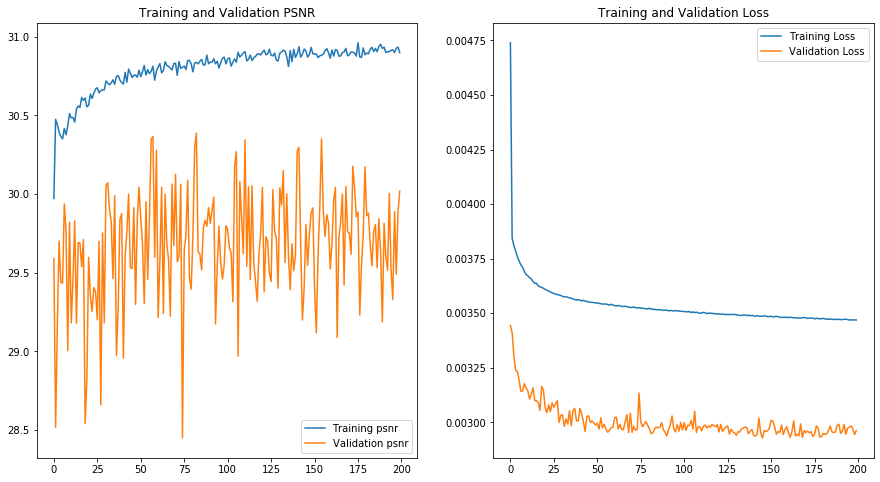

In [0]:
psnr = history.history['PSNR']
val_psnr = history.history['val_PSNR']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, psnr, label='Training psnr')
plt.plot(epochs_range, val_psnr, label='Validation psnr')
plt.legend(loc='lower right')
plt.title('Training and Validation PSNR')
plt.savefig('psnr.png')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig('mse.png')
plt.show()

In [0]:
import yaml
file_data = [{
    'optimizer_name': OP_NAME,
    'optimizer_size': OP_SIZE,
    'sr_factor': SR_FACTOR,
    'epoch': EPOCHS,
    'loss': LOSS,
    'batch_size': BATCH_SIZE,
    'training_image_size': '32x32',
    'interpolation': 'bicubic',
    'psnr_chanel': 'YCrCb',
    'train_patch': PATCH_SIZE,
    'Padding': 'None',
}]


with open(r'model_info.yaml', 'w') as file:
    documents = yaml.dump(file_data, file)

In [0]:
srcnn.save('train_model.h5')
from shutil import copyfile
dst = os.path.join(os.getcwd(), 'SRCNN_checkpoint.h5')
copyfile('/content/SRCNN_checkpoint.h5', dst)

'/content/drive/My Drive/project/super-resolution/SRCNN/SRCNN_LRLU/SRCNN_X3_L3_P_Zero_Emse/SRCNN_checkpoint.h5'

# Super Resolve images

In [0]:
os.chdir('/content')

In [0]:
def predict_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(128, (9, 9), input_shape=(None, None, 1), padding='valid'))
    model.add(layers.LeakyReLU())
    model.add(layers.Conv2D(64, (3,3), padding='valid'))
    model.add(layers.LeakyReLU())
    model.add(layers.Conv2D(1, (5, 5), activation='linear', padding='valid'))
    adam = tf.keras.optimizers.Adam(3e-4)

    model.compile(optimizer=adam,
                  loss='mse',
                  metrics=['mean_squared_error', PSNR])
    
    return model

In [0]:
def predict(model, sr_factor, img_path, save_path):
    IMG_NAME = img_path
    INPUT_NAME = "input2.jpg"
    OUTPUT_NAME = "pre2.jpg"

    import cv2
    img = cv2.imread(IMG_NAME, cv2.IMREAD_COLOR)
    im1 = img

    img = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    shape = img.shape
    Y_img = cv2.resize(img[:, :, 0], (shape[1] // sr_factor, shape[0] // sr_factor), cv2.INTER_CUBIC)
    Y_img = cv2.resize(Y_img, (shape[1], shape[0]), cv2.INTER_CUBIC)
    img[:, :, 0] = Y_img
    img = cv2.cvtColor(img, cv2.COLOR_YCrCb2BGR)
    im2 = img

    Y = np.zeros((1, img.shape[0], img.shape[1], 1), dtype=float)
    Y[0, :, :, 0] = Y_img.astype(float) / 255.
    pre = model.predict(Y, batch_size=1) * 255.
    pre[pre[:] > 255] = 255
    pre[pre[:] < 0] = 0
    pre = pre.astype(np.uint8)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    print(pre.shape)
    print(img.shape)    
    
    if CONVOLUTION_SIZE != 0:
        img[CONVOLUTION_SIZE: -CONVOLUTION_SIZE, CONVOLUTION_SIZE: -CONVOLUTION_SIZE, 0] = pre[0, :, :, 0]
    else:
        img[0:,0:,0] = pre[0, :, :, 0]

    img = cv2.cvtColor(img, cv2.COLOR_YCrCb2BGR)
    im3 = img
    print("im3 "+ str(im3.shape)+" im1 "+str(im1.shape))
    cv2.imwrite(save_path, im3)
     
    # psnr calculation:
    im = []
    im.append(cv2.cvtColor(im1, cv2.COLOR_RGB2BGR))
    im.append(cv2.cvtColor(im2, cv2.COLOR_RGB2BGR))
    im.append(cv2.cvtColor(im3, cv2.COLOR_RGB2BGR))

    im1 = cv2.cvtColor(im1, cv2.COLOR_BGR2YCrCb)[CONVOLUTION_SIZE: -CONVOLUTION_SIZE, CONVOLUTION_SIZE: -CONVOLUTION_SIZE, 0]
    im2 = cv2.cvtColor(im2, cv2.COLOR_BGR2YCrCb)[CONVOLUTION_SIZE: -CONVOLUTION_SIZE, CONVOLUTION_SIZE: -CONVOLUTION_SIZE, 0]
    im3 = cv2.cvtColor(im3, cv2.COLOR_BGR2YCrCb)[CONVOLUTION_SIZE: -CONVOLUTION_SIZE, CONVOLUTION_SIZE: -CONVOLUTION_SIZE, 0]

    fig, axes = plt.subplots(1, 3, figsize=(20, 20))
    for i, ax in enumerate(axes):
        ax.set_title(i)
        ax.set_xlabel(math.inf if cv2.PSNR(im[0], im[i]) > 300 else cv2.PSNR(im[0], im[i]))
        ax.imshow(im[i])

   

In [17]:
predict_srcnn = predict_model()
predict_srcnn.summary()
weights_file = 'SRCNN_checkpoint.h5'
predict_srcnn.load_weights(weights_file)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, None, None, 128)   10496     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, None, None, 128)   0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, None, None, 64)    73792     
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, None, None, 64)    0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, None, None, 1)     1601      
Total params: 85,889
Trainable params: 85,889
Non-trainable params: 0
_________________________________________________________________


## Save test model

In [0]:
os.chdir(DRIVE_PATH + name)
predict_srcnn.save('test_model.h5')

# Visualize Layer by layer output

In [20]:
import keract, cv2
image = cv2.imread('/content/Set5/butterfly.png', cv2.IMREAD_COLOR)
image = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)
y_image = image[:, :, 0]
y_image = np.reshape(y_image, (1, image.shape[0], image.shape[1], 1))

activations = keract.get_activations(predict_srcnn, y_image)
keract.display_activations(activations, cmap='gray', save=True)

conv2d_3 (1, 248, 248, 128) 
leaky_re_lu_2 (1, 248, 248, 128) 
conv2d_4 (1, 246, 246, 64) 
leaky_re_lu_3 (1, 246, 246, 64) 
conv2d_5 (1, 242, 242, 1) 


# Visualize Filters


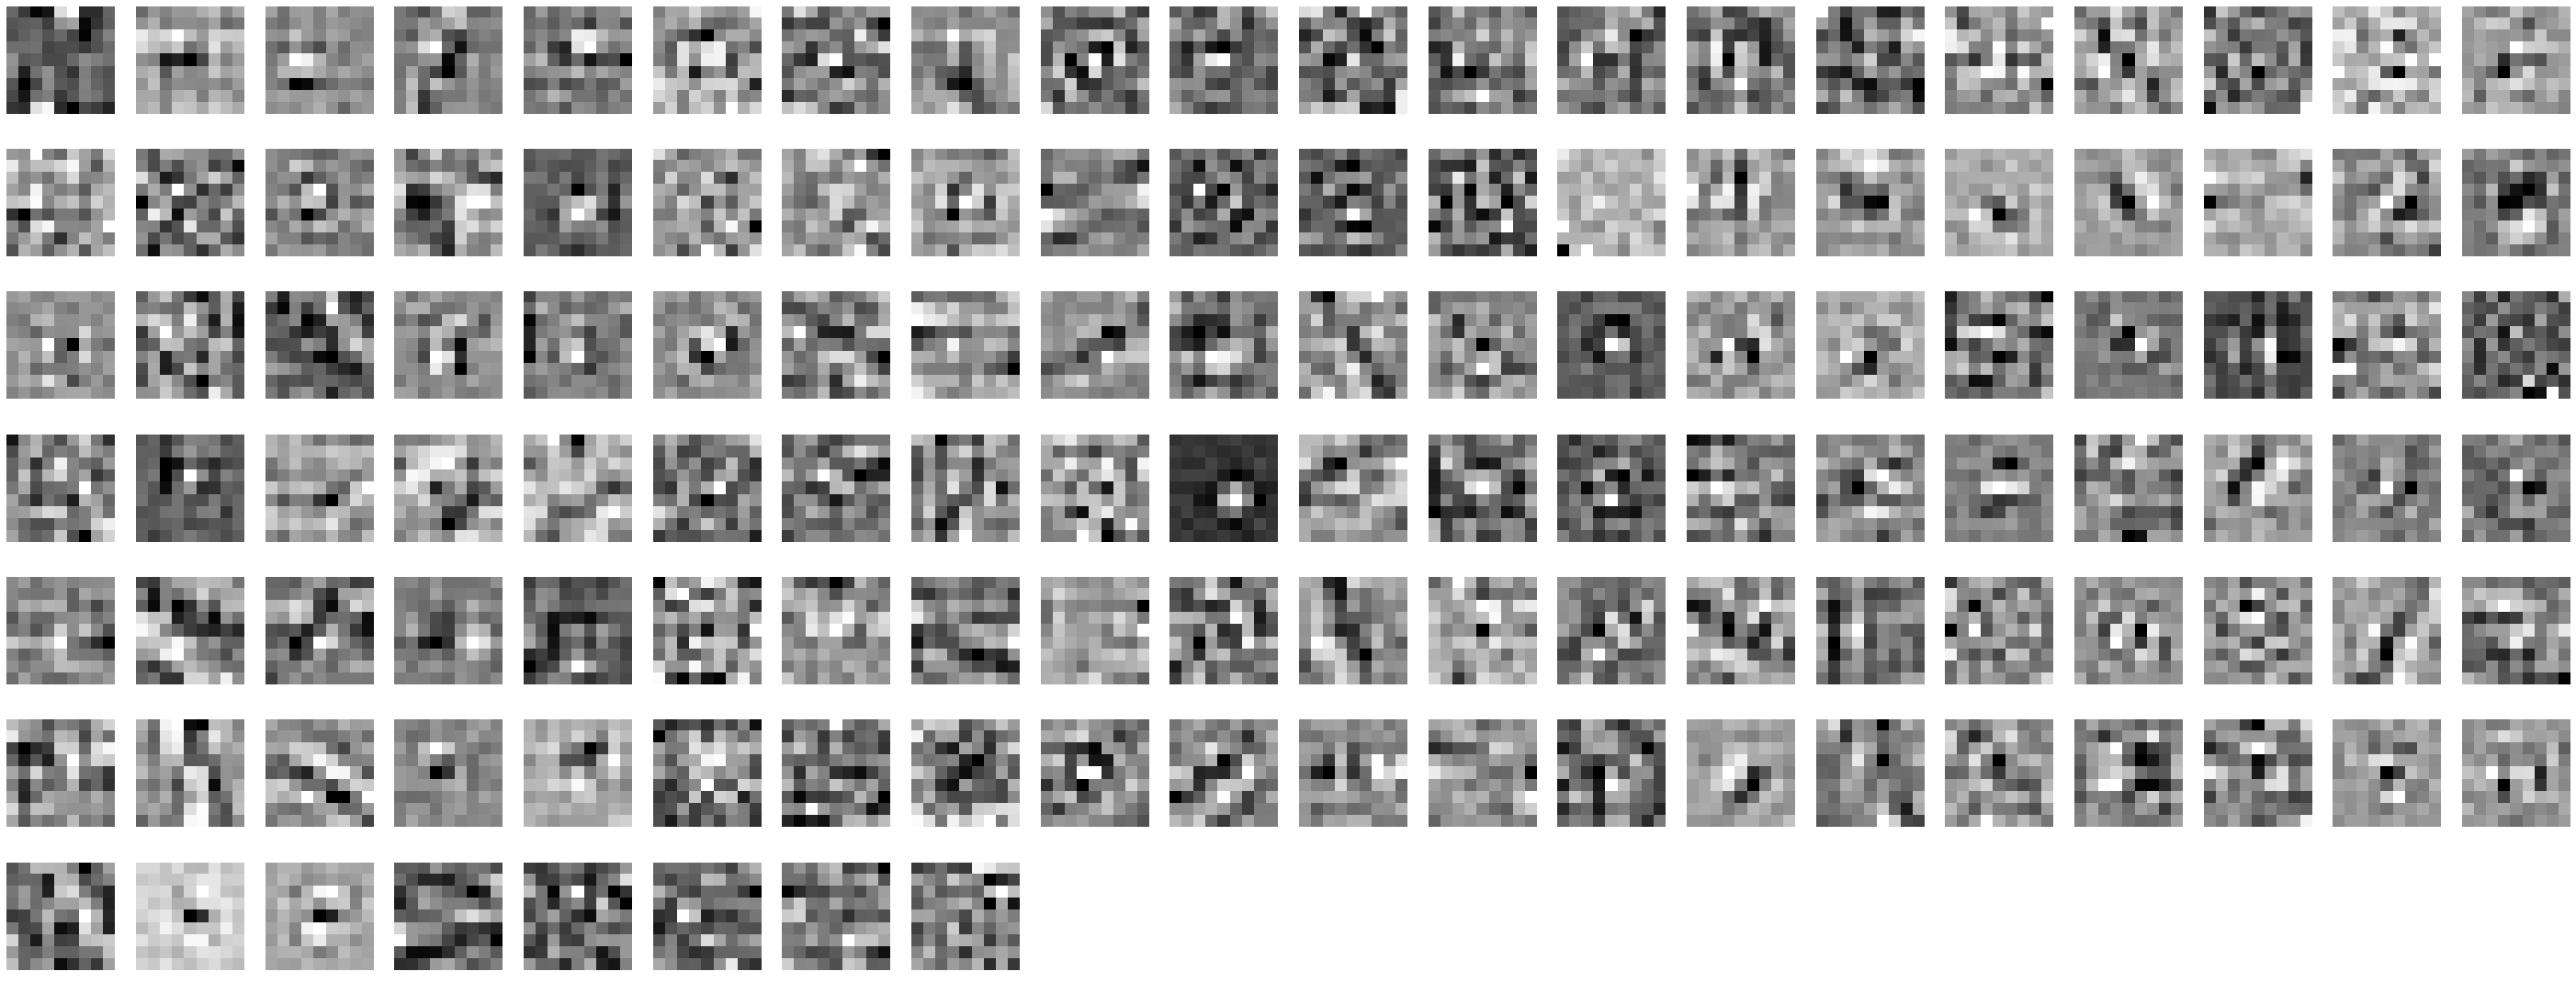

In [91]:
filters, _ = predict_srcnn.layers[0].get_weights()
num_filters = filters.shape[3]
def save_filters(filters, num_filters):
    import math
    ncols = 20
    nrows = math.ceil(num_filters / ncols)
    fig, axes = plt.subplots(nrows, ncols, figsize=(50, 20))
    for i in range(nrows * ncols):
        if i < num_filters:
            axes.flat[i].imshow(filters[:, :, 0, i], cmap='gray')
        axes.flat[i].axis('off')
    fig.subplots_adjust(hspace=0)
    plt.savefig('filters.png')
save_filters(filters, num_filters)

In [0]:
def save_filters(filters, num_filters):
    import math
    ncols = 20
    nrows = math.ceil(num_filters / ncols)
    fig, axes = plt.subplots(nrows, ncols, figsize=(5, 20), squeeze=True)
    for i in range(nrows * ncols):
        if i < num_filters:
            axes.flat[i].imshow(filters[:, :, 0, i], cmap='gray', interpolation='nearest')
        axes.flat[i].axis('off')
    plt.savefig('filters.png')
    
def print_filters(filters, num_filters):
    c = 0
    figure = plt.figure()
    while num_filters: 
        per_row = 20
        num_plt_ft = per_row if num_filters-per_row > 0 else num_filters
        num_filters -= num_plt_ft
        axs = figure.subplots(1, num_plt_ft)
        for ax in axs:
            ax.set_xticks([])
            ax.set_yticks([])
            ax.imshow(filters[:, :, 0, c], cmap='gray', squeeze=True, interpolation='nearest')
            c += 1


# Save Results

In [0]:
folder = '/content/Set5/'
if not os.path.exists('Set5'):
    os.mkdir('Set5')
save_folder = os.path.join(os.getcwd(),'Set5/')  
for file in os.listdir(folder):
    path = folder + file
    save_path = save_folder + file
    predict(predict_srcnn, sr_factor=SR_FACTOR, img_path=path, save_path=save_path)

Output hidden; open in https://colab.research.google.com to view.

In [0]:
folder = '/content/Set14/'
if not os.path.exists('Set14'):
    os.mkdir('Set14')
save_folder = os.path.join(os.getcwd(),'Set14/')  
for file in os.listdir(folder):
    path = folder + file
    save_path = save_folder + file
    predict(predict_srcnn, sr_factor=SR_FACTOR, img_path=path, save_path=save_path)

Output hidden; open in https://colab.research.google.com to view.